# SD-TSIA211 : TP2 - BREAST CANCER DATA ANALYSIS

## Remi Jaylet & Romain Louvet

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1 - Data

In [2]:
def load_breastcancer(filename):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'wdbc_M1_B0.data'
    Elle retourne 
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, la tumeur est maligne
        et si y[i] = -1, la tumeur est benigne

    Pour plus d'infos sur la base de donnees,
    https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Prognostic%29
    """

    data = np.loadtxt(filename, delimiter=',')

    # la colonne 0 ne nous interesse pas ici
    y = data[:, 1] * 2 - 1
    X = data[:, 2:]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    return X, y

In [3]:
X, y = load_breastcancer("wdbcM1B0.data")

### 2 - Sub-gradient method

#### Question 2.1

According to the the two inequalties in the text, we have : $$ \forall i, \xi_{i} \geq max(0,1-y_{i}(x_{i}^Tv+a)) $$

As the left term of two expressions are the same, the difference is in the reformulation of xi_i. However it is equivalent to minimize $$ \forall i, \xi_{i} \quad \textrm{and} \quad max(0,1-y_{i}(x_{i}^Tv+a)) $$

Thus, the two expressions are equivalent.

#### Question 2.2

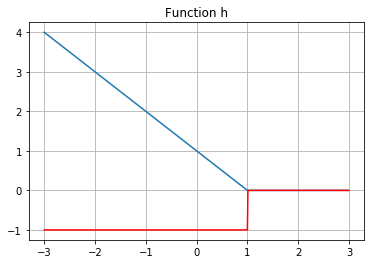

In [4]:
def h(z):
    return np.maximum(np.zeros(z.shape),1-z)

def d(z):
    res = []
    for i in range(len(z)):
        if z[i] < 1 :
            res.append(-1)
        elif z[i] > 1 :
            res.append(0)
        else : 
            res.append(arange(0,1,0.01))
    return res

x=np.arange(-3,3,0.01)

plt.plot(x,h(x))
plt.plot(x,d(x), color = "red")
plt.title("Function h")
plt.grid()

plt.show()

For all z != 1, h is differentiable. Pour z = 1, we can see that all the slopes between -1 and 0 can fit. The expression of the subject is thus correct.


#### Question 2.3

For the two seperable expressions, we take :

$$ N(v)=\frac{1}{2} \sum_{i=1}^{m+1} n_i(v_i) \quad \textrm{and} \quad H(v)=\frac{1}{2} \sum_{i=1}^{m+1} h_i(v_i) $$

with $$ \forall i \in [1,n],  n_i(v_i)=v_i² \quad \textrm{and} \quad h_i(v_i)=max(0, 1 - v_i) $$

N and H are well seperable.
For the linear application, we have the following expression : $$ M(v) = y_{i}(x_{i}^Tv+a) $$


Hence, $f(v,a) = N(v,a) + cH(M(v,a))$



As N is differentiable, we have :  $\partial N(v,a) = (v, 0)$
As H is seperable, we have : $\partial H(M(v,a)) = \prod_i \partial h(M_i(v,a)) = \prod_i \partial h(y_i(x_i^Tv+a))$

We differentiate the function f is $\partial f(v,a) = \partial N(v,a) + cM^T \partial H (M(v,a)).$


#### Question 2.4

In [41]:
c = 1
M = np.dot(np.diag(y), np.concatenate([X, np.ones((569,1))], axis = 1))


def N(va):
    return (1/2) * np.sum(va[:-1]**2)

def H(va):
    return np.sum(h(np.dot(M,va)))

def f(va):
    return N(va) + c * H(va)

def dev_N(va):
    return np.concatenate([va[:-1], [0]])

def dev_H(va):
    return np.dot(np.transpose(M), (np.dot(M,va)>=1) - 1)

def dev_f(va):
    return dev_N(va) + c * dev_H(va)


#### Question 2.5

In [42]:
def sub_gradient(va0, N):
    """
        implementation of the subgradient method explained i nthe subject
    """
    sum_gamma = 0
    sum_va = np.zeros(va0.shape)
    for k in range(N):
        gamma = 1/(k+1)
        sum_gamma += gamma
        sum_va += va0*gamma
        va0 = va0-gamma*dev_f(va0)
    return sum_va/sum_gamma

In [43]:
va0 = np.zeros((31,))
print("Initial value of f :", f(va0))
va1 = sub_gradient(va0, 10000)
print("Final value of f :",f(va1))

Initial value of f : 569.0
Final value of f : 16989.301940798585


### 3 - Stochastic subgradient method

#### Question 3.1

$$ E(f_I(v,a)) = \sum_i P(I = i) \times f_i(v,a) = \frac{1}{n}\sum_i f_i(v,a) $$

Hence, $$ E(f_I(v,a)) = \frac{1}{2n} \sum_j n\,v_j^2 + \frac{1}{n}\sum_i c\,n\,max(0,1-y_i(x_i^Tv + a))$$ 

Thus, $$ E(f_I(v,a)) = \frac{1}{2} \sum_j v_j^2 + c\sum_i max(0,1-y_i(x_i^Tv + a))= f(v,a)$$

#### Question 3.2

$$\partial f_i(v,a) = \partial N(v,a) + c\, n\, M_i^T\partial H(M_i(v,a)) $$

#### Question 3.3

In [39]:
def dev_H_i(va, i):
    return ((np.dot(M[i,:],va)>=1)- 1) * M[i,:]

def dev_f_i(va, i):
    return dev_N(va) +  M.shape[0] * dev_H_i(va,i)

def stochastic_gradient(va0, N):
    """
    implementatio nof the stochastic gradient method
    """
    n = M.shape[0]
    sum_gamma = 0
    sum_va = np.zeros(va0.shape)
    for k in range(N):
        I = np.random.randint(n)  # select one random element
        gamma = 1/(k+1)
        sum_gamma += gamma
        sum_va += va0*gamma
        va0 = va0-gamma*dev_f_i(va0,I)  # multiply by the random element selected
    return sum_va/sum_gamma

In [40]:
va0 = np.zeros((31,))
print("Initial value of f :",f(va0))
va1 = stochastic_gradient(va0, 100000)
print("Final value of f :",f(va1))

Initial value of f : 569.0
Final value of f : 55244.8425308796


### 4 - Augmented Lagrangian method

#### Question 4.1

The lagrangian problem of (1) is written : $L(v, a, \xi, \phi) = \frac{1}{2} \sum_jv_j^2 + c\sum_i\xi_i + \sum_i\phi_i \times (1-M_i(v,a)-\xi_i) + \sum_i \iota_{R_+}(\phi_i)$

#### Question 4.2

$$ f(x) = \frac{\rho}{2}(max(0,x))^2 $$
$$ h(x, \phi) = x+\frac{\phi}{\rho} $$

$$ \nabla_x g(x,\phi) = h_x'(x,\phi) \, f'( h(x,\phi) ) $$

$$ \nabla_\phi g(x,\phi) = h_\phi'(x,\phi) \, f'( h(x,\phi) ) $$


#### Question 4.3

$ \nabla_xg(x, \phi) $ is an increasing function as $ \forall x,y \, \nabla_xg(x, \phi) - \nabla_xg(x, \phi) \geq 0 $

$ \nabla_\phi g(x, \phi) $ is an decreasing function as $ \forall \phi1,\phi2 \, \nabla_{\phi1} g(x, \phi1) - \nabla_{\phi2} g(x, \phi2) \geq 0 $

So we have $x \mapsto g(x,\phi) \ convex $ and $ \phi\mapsto g(x,\phi) \ concave $

#### Question 4.4

In [49]:
rho = 2
eps = 1

def nabla_g_x(x, phi):
    return rho * np.maximum(np.zeros(x.shape), x + phi/rho)

def nabla_g_phi(x, phi):
    return np.maximum(-phi/rho, x)

def min_L(phi, psi, eps):
    """
        seach of the Lagrangian minimum
    """
    
    # initialization of the variables
    v = np.zeros((30,))
    a = 0
    xi = np.zeros((569,))
    
    # initialization of the variatio nof the variables
    dv = np.zeros((30,))
    da = 1.5
    dxi = np.zeros((569,))
    
    while (np.sum(dv**2)+da**2+np.sum(dxi**2)>1) > 1:
        
        x = 1-xi-np.dot(np.diag(y), np.dot(X, v) + a)

        # implement graident of each variables
        dv = v - np.transpose(np.dot(np.dot(np.diag(y), X)), nabla_g_x(x, psi))
        da = -np.sum(y * nabla_g_x(x,psi))
        dxi = c - nabla_g_x(-xi, phi) - nabla_g_x(x, psi)
        
        gamma = 1/100
        v -= gamma * dv
        a -= gamma * da
        xi -= gamma * dxi 
        
    return v, a, xi
  

#### Question 4.5

In [50]:
def nabla_phi_L(v,a,xi,phi,psi):
    return nabla_phi_g(-xi, phi)

def nabla_psi_L(v,a,xi,phi,psi):
    x = 1-xi-np.dot(np.diag(y), np.dot(X, v) + a)
    return nabla_phi_g(x, psi)

#### Question 4.6

### 5 - Comparison

#### Question 5.1